In [150]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
import math
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass, field
from cortical_maps import *

In [152]:
ADF = 1


@dataclass
class AppDataRetina:
    distAPON: float = 5.0
    distMLON: float = 5.0
    distAPOFF: float = 5.0
    distMLOFF: float = 5.0
    jitterONx: float = 0.1
    jitterONy: float = 0.1
    jitterOFFx: float = 0.15
    jitterOFFy: float = 0.15
    MinDistONOFF: float = 1.0
    MaxDistONOFF: float = 3.4
    aff_density_factor: float = ADF


@dataclass
class AppData:
    rng_trial: int = 0
    electrode_position: int = 10
    num_electrode: int = 10
    alpha: float = 0.6
    n_interpol: int = 4
    od_contour_levels: int = 1
    od_contour: int = 1
    contra_font_color: np.ndarray = np.array([0, 0, 0], dtype=np.uint8) / 255
    ipsi_font_color: np.ndarray = np.array([245, 134, 52], dtype=np.uint8) / 255
    pix2mic: int = 22
    crtx_length: int = 40
    retina: AppDataRetina = field(default_factory=AppDataRetina)

    @property
    def CrtxLength(self):
        return self.crtx_length

    @property
    def CrtxWidth(self):
        return self.crtx_length

    @property
    def rowRange(self):
        return np.arange(self.CrtxLength) + 1

    @property
    def colRange(self):
        return np.arange(self.CrtxLength) + 1


appdata = AppData()
appdata

AppData(rng_trial=0, electrode_position=10, num_electrode=10, alpha=0.6, n_interpol=4, od_contour_levels=1, od_contour=1, contra_font_color=array([0., 0., 0.]), ipsi_font_color=array([0.96078431, 0.5254902 , 0.20392157]), pix2mic=22, crtx_length=40, retina=AppDataRetina(distAPON=5.0, distMLON=5.0, distAPOFF=5.0, distMLOFF=5.0, jitterONx=0.1, jitterONy=0.1, jitterOFFx=0.15, jitterOFFy=0.15, MinDistONOFF=1.0, MaxDistONOFF=3.4, aff_density_factor=1))

In [153]:
jitter_seed = appdata.rng_trial  # Jitter seed number

ADF = appdata.retina.aff_density_factor  # afferent density factor

distAPON = appdata.retina.distAPON
distMLON = appdata.retina.distMLON
distAPOFF = appdata.retina.distAPOFF
distMLOFF = appdata.retina.distMLOFF

dist_on_x = distAPON  # 5 (Anterior Posterior)
dist_on_y = distMLON  # 5 (Medio Lateral)
dist_off_x = distAPOFF  # 5
dist_off_y = distMLOFF  # 5
dist_min = min(dist_on_x, dist_on_y, dist_off_x, dist_off_y)
appdata.retina.dist_min_RGC = dist_min

In [154]:
jitterONx = appdata.retina.jitterONx
jitterONy = appdata.retina.jitterONy
jitterOFFx = appdata.retina.jitterOFFx
jitterOFFy = appdata.retina.jitterOFFy

ON_jx = dist_on_x * jitterONx
ON_jy = dist_on_y * jitterONy
OFF_jx = dist_off_x * jitterOFFx
OFF_jy = dist_off_y * jitterOFFy

In [155]:
CrtxLength = appdata.CrtxLength
MinDistONOFF = appdata.retina.MinDistONOFF
MaxDistONOFF = appdata.retina.MaxDistONOFF
pix2mic = appdata.pix2mic

In [156]:
# Measure width of RF space
num_cell = CrtxLength**2

# 4 because there are two eyes and two polarities
Width_rf_space_onx = math.ceil(math.sqrt((num_cell / 4) * (dist_on_x**2)))
Width_rf_space_ony = math.ceil(math.sqrt((num_cell / 4) * (dist_on_y**2)))
Width_rf_space_offx = math.ceil(math.sqrt((num_cell / 4) * (dist_off_x**2)))
Width_rf_space_offy = math.ceil(math.sqrt((num_cell / 4) * (dist_off_y**2)))

In [157]:
# Number of Cells each eye
OFF_ON_ratio = 1  # Number of OFF to ON cell ratio
Contra_ipsi_ratio = 1  # Number of Contra to Ipsi cell ratio

num_cell_contra = (num_cell / (Contra_ipsi_ratio + 1)) * Contra_ipsi_ratio
num_cell_contra = math.ceil(num_cell_contra)
num_cell_ipsi = num_cell - num_cell_contra

In [158]:
# Contra
num_OFF_contra = (num_cell_contra / (OFF_ON_ratio + 1)) * OFF_ON_ratio
num_OFF_contra = math.ceil(num_OFF_contra)
num_ON_contra = num_cell_contra - num_OFF_contra

In [159]:
# on
num_ONx_contra = int(math.sqrt(num_ON_contra))
num_ONy_contra = num_ONx_contra
max_rangeX_ON_contra = round(Width_rf_space_onx)
max_rangeY_ON_contra = Width_rf_space_ony
range_ONx_contra = np.linspace(dist_on_x, max_rangeX_ON_contra, num_ONx_contra)
range_ONy_contra = np.linspace(dist_on_y, max_rangeY_ON_contra, num_ONy_contra)

In [160]:
# off
num_OFFx_contra = int(math.sqrt(num_OFF_contra))
num_OFFy_contra = num_OFFx_contra
max_rangeX_OFF_contra = round(Width_rf_space_offx)
max_rangeY_OFF_contra = Width_rf_space_offy
range_OFFx_contra = np.linspace(dist_off_x, max_rangeX_OFF_contra, num_OFFx_contra)
range_OFFy_contra = np.linspace(dist_off_y, max_rangeY_OFF_contra, num_OFFy_contra)

In [161]:
# ipsi
num_OFF_ipsi = (num_cell_ipsi / (OFF_ON_ratio + 1)) * OFF_ON_ratio
num_OFF_ipsi = math.ceil(num_OFF_ipsi)
num_ON_ipsi = num_cell_ipsi - num_OFF_ipsi

In [162]:
# on
num_ONx_ipsi = int(math.sqrt(num_ON_ipsi))
num_ONy_ipsi = num_ONx_ipsi
max_rangeX_ON_ipsi = round(Width_rf_space_onx)
max_rangeY_ON_ipsi = Width_rf_space_ony
range_ONx_ipsi = np.linspace(dist_on_x, max_rangeX_ON_ipsi, num_ONx_ipsi)
range_ONy_ipsi = np.linspace(dist_on_y, max_rangeY_ON_ipsi, num_ONy_ipsi)

In [163]:
# off
num_OFFx_ipsi = int(math.sqrt(num_OFF_ipsi))
num_OFFy_ipsi = num_OFFx_ipsi
max_rangeX_OFF_ipsi = round(Width_rf_space_offx)
max_rangeY_OFF_ipsi = Width_rf_space_offy
range_OFFx_ipsi = np.linspace(dist_off_x, max_rangeX_OFF_ipsi, num_OFFx_ipsi)
range_OFFy_ipsi = np.linspace(dist_off_y, max_rangeY_OFF_ipsi, num_OFFy_ipsi)

In [164]:
def ONOFF_retina_grid3(
    temp_xON,
    temp_yON,
    temp_xOFF,
    temp_yOFF,
    RfsizeRet,
    ON_jx,
    ON_jy,
    OFF_jx,
    OFF_jy,
    min_onoff,
    max_onoff,
    rng_trial,
):
    rng = np.random.default_rng(seed=rng_trial)

    ON_x = np.zeros_like(temp_xON)
    ON_y = np.zeros_like(temp_yON)
    OFF_x = np.zeros_like(temp_xOFF)
    OFF_y = np.zeros_like(temp_yOFF)

    delta_y = np.zeros((len(temp_xON)))
    delta_x = np.zeros((len(temp_xON)))
    dist_onoff_old = np.zeros((len(temp_xON)))
    angle = np.zeros((len(temp_xON)))
    closest_off_ind = np.zeros(shape=(len(temp_xON)), dtype=np.int64)
    new_dist = np.zeros((len(temp_xON)))
    move_dist = np.zeros((len(temp_xON)))
    New_ON_x = np.zeros((len(temp_xON)))
    New_ON_y = np.zeros((len(temp_xON)))

    # adding jitter
    for ii in range(len(temp_xON)):
        ON_x[ii] = temp_xON[ii] + (rng.random() - 0.5) * 2 * ON_jx
        ON_y[ii] = temp_yON[ii] + (rng.random() - 0.5) * 2 * ON_jy

    for ii in range(len(temp_xOFF)):
        OFF_x[ii] = temp_xOFF[ii] + (rng.random() - 0.5) * 2 * OFF_jx
        OFF_y[ii] = temp_yOFF[ii] + (rng.random() - 0.5) * 2 * OFF_jy

    # measuring the distance of the closest RGCs with different polairty
    for on_n in range(len(temp_xON)):
        disonofftemp = np.sqrt((OFF_x - ON_x[on_n]) ** 2 + (OFF_y - ON_y[on_n]) ** 2)
        ind_closest_off = np.argmin(disonofftemp.flatten(order="F"))
        closes_dist_onoff = disonofftemp[ind_closest_off]
        delta_y[on_n] = -OFF_y[ind_closest_off] + ON_y[on_n]
        delta_x[on_n] = -OFF_x[ind_closest_off] + ON_x[on_n]
        dist_onoff_old[on_n] = closes_dist_onoff
        angle[on_n] = np.arctan2(delta_y[on_n], delta_x[on_n])
        closest_off_ind[on_n] = ind_closest_off

    max_dist = np.amax(dist_onoff_old)
    min_dist = np.amin(dist_onoff_old)
    m = (max_onoff - min_onoff) / (max_dist - min_dist)

    New_OFF_x = OFF_x.copy()
    New_OFF_y = OFF_y.copy()
    for on_n in range(len(temp_xON)):
        new_dist[on_n] = min_onoff + m * (dist_onoff_old[on_n] - min_dist)

        # moving both ON and OFF
        move_dist[on_n] = (new_dist[on_n] - dist_onoff_old[on_n]) / 2

        if delta_y[on_n] > 0 and delta_x[on_n] > 0:
            project_angle_sin = np.abs(np.sin(angle[on_n]))
            project_angle_cos = np.abs(np.cos(angle[on_n]))
        elif delta_y[on_n] > 0 and delta_x[on_n] < 0:
            project_angle_sin = np.abs(np.sin(angle[on_n]))
            project_angle_cos = -np.abs(np.cos(angle[on_n]))
        elif delta_y[on_n] < 0 and delta_x[on_n] < 0:
            project_angle_sin = -np.abs(np.sin(angle[on_n]))
            project_angle_cos = -np.abs(np.cos(angle[on_n]))
        elif delta_y[on_n] < 0 and delta_x[on_n] > 0:
            project_angle_sin = -np.abs(np.sin(angle[on_n]))
            project_angle_cos = np.abs(np.cos(angle[on_n]))
        New_OFF_x[closest_off_ind[on_n]] = (
            OFF_x[closest_off_ind[on_n]] - move_dist[on_n] * project_angle_cos
        )
        New_OFF_y[closest_off_ind[on_n]] = (
            OFF_y[closest_off_ind[on_n]] - move_dist[on_n] * project_angle_sin
        )
        New_ON_x[on_n] = ON_x[on_n] + move_dist[on_n] * project_angle_cos
        New_ON_y[on_n] = ON_y[on_n] + move_dist[on_n] * project_angle_sin

    return New_ON_x, New_ON_y, New_OFF_x, New_OFF_y

In [165]:
ONx_Grid_contra, ONy_Grid_contra = np.meshgrid(range_ONx_contra, range_ONy_contra)
OFFx_Grid_contra, OFFy_Grid_contra = np.meshgrid(range_OFFx_contra, range_OFFy_contra)
RetONxContra, RetONyContra, RetOFFxContra, RetOFFyContra = ONOFF_retina_grid3(
    ONx_Grid_contra.flatten(order="F"),
    ONy_Grid_contra.flatten(order="F"),
    OFFx_Grid_contra.flatten(order="F"),
    OFFy_Grid_contra.flatten(order="F"),
    [],
    ON_jx,
    ON_jy,
    OFF_jx,
    OFF_jy,
    MinDistONOFF,
    MaxDistONOFF,
    jitter_seed,
)

In [166]:
ONx_Grid_ipsi, ONy_Grid_ipsi = np.meshgrid(range_ONx_ipsi, range_ONy_ipsi)
OFFx_Grid_ipsi, OFFy_Grid_ipsi = np.meshgrid(range_OFFx_ipsi, range_OFFy_ipsi)
RetONxIpsi, RetONyIpsi, RetOFFxIpsi, RetOFFyIpsi = ONOFF_retina_grid3(
    ONx_Grid_ipsi.flatten(order="F"),
    ONy_Grid_ipsi.flatten(order="F"),
    OFFx_Grid_ipsi.flatten(order="F"),
    OFFy_Grid_ipsi.flatten(order="F"),
    [],
    ON_jx,
    ON_jy,
    OFF_jx,
    OFF_jy,
    MinDistONOFF,
    MaxDistONOFF,
    jitter_seed + 1,
)

In [167]:
TotalRetinaCells = (
    len(RetONxContra) + len(RetOFFxContra) + len(RetONxIpsi) + len(RetOFFxIpsi)
)
RetinaAllX = np.concatenate(
    [RetONxContra, RetOFFxContra, RetONxIpsi, RetOFFxIpsi], axis=0
)
RetinaAllY = np.concatenate(
    [RetONyContra, RetOFFyContra, RetONyIpsi, RetOFFyIpsi], axis=0
)
RetinaAllOD = np.concatenate(
    [
        +1 * np.ones(shape=len(RetONxContra)),
        +1 * np.ones(shape=len(RetOFFxContra)),
        -1 * np.ones(shape=len(RetONxIpsi)),
        -1 * np.ones(shape=len(RetOFFxIpsi)),
    ],
    axis=0,
)
RetinaAllONOFF = np.concatenate(
    [
        +1 * np.ones(shape=len(RetONxContra)),
        -1 * np.ones(shape=len(RetOFFxContra)),
        +1 * np.ones(shape=len(RetONxIpsi)),
        -1 * np.ones(shape=len(RetOFFxIpsi)),
    ],
    axis=0,
)

BoundXL = math.floor(np.amin(RetinaAllX)) - 2
BoundXR = math.ceil(np.amax(RetinaAllX)) + 2
BoundYL = math.floor(np.amin(RetinaAllY)) - 2
BoundYR = math.ceil(np.amax(RetinaAllY)) + 2

BoundL = min(BoundXL, BoundYL)
BoundU = max(BoundXR, BoundYR)

# make rf space
rf_space_x, rf_space_y = np.meshgrid(
    np.arange(BoundL, BoundU + 1), np.arange(BoundL, BoundU + 1)
)

appdata.RetONxContra = RetONxContra
appdata.RetONyContra = RetONyContra
appdata.RetOFFxContra = RetOFFxContra
appdata.RetOFFyContra = RetOFFyContra
appdata.rf_space_x = rf_space_x
appdata.rf_space_y = rf_space_y

In [168]:
# afferent sorting filter parameter based on RGC distribution
XY_ratio = dist_on_x / dist_on_y

CenterRadiusX = (5 / dist_min) * 5  # 5 is the base value we used in the

if CenterRadiusX < 3:
    # 3 arbitrary number, I could add more options for RGC distance and the
    # aff_sampling_density would be lower than 1 automatically,
    # but the running time increases for larger initial RGC
    # distance because it increases the visual space size
    CenterRadiusX = 0.5

CenterRadiusX = CenterRadiusX * ADF
CenterRadiusY = CenterRadiusX
large_surround_filter_size = CenterRadiusX * 2
if XY_ratio == 1:
    SurroundRadiusX = large_surround_filter_size
    SurroundRadiusY = large_surround_filter_size
elif XY_ratio > 1:
    SurroundRadiusX = CenterRadiusX
    SurroundRadiusY = large_surround_filter_size
elif XY_ratio < 1:
    SurroundRadiusX = large_surround_filter_size
    SurroundRadiusY = CenterRadiusX

In [169]:
appdata.RetinaAllX = RetinaAllX
appdata.RetinaAllY = RetinaAllY
appdata.RetinaAllOD = RetinaAllOD
appdata.RetinaAllONOFF = RetinaAllONOFF
appdata.TotalRetinaCells = TotalRetinaCells

appdata.CenterRadiusX = CenterRadiusX
appdata.CenterRadiusY = CenterRadiusY
appdata.SurroundRadiusX = SurroundRadiusX
appdata.SurroundRadiusY = SurroundRadiusY

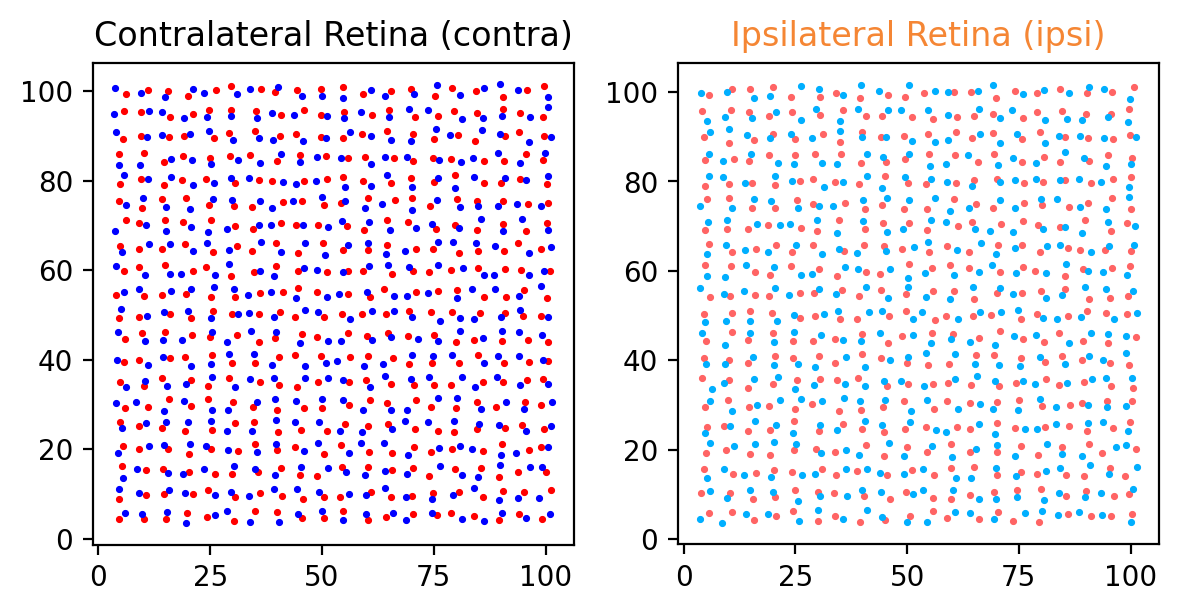

In [170]:
def plot_retina(ax, eye_input):
    RetinaAllOD = appdata.RetinaAllOD
    RetinaAllONOFF = appdata.RetinaAllONOFF
    RetinaAllX = appdata.RetinaAllX
    RetinaAllY = appdata.RetinaAllY

    if eye_input == 'contra':
        sign_od = +1
        color_on  = np.array([1, 0, 0])
        color_off = np.array([0, 0, 1])
        contra_font_color = appdata.contra_font_color
    elif eye_input == 'ipsi':
        sign_od = -1
        color_on  = np.array([255, 100, 100]) /255
        color_off = np.array([0, 175, 255]) /255
        ipsi_font_color = appdata.ipsi_font_color

    RetONx = RetinaAllX[(RetinaAllOD == sign_od) & (RetinaAllONOFF == +1)]
    RetONy = RetinaAllY[(RetinaAllOD == sign_od) & (RetinaAllONOFF == +1)]
    RetOFFx = RetinaAllX[(RetinaAllOD == sign_od) & (RetinaAllONOFF == -1)]
    RetOFFy = RetinaAllY[(RetinaAllOD == sign_od) & (RetinaAllONOFF == -1)]

    ax.scatter(RetONx.flat, RetONy.flat, marker='.', color=color_on, s=10)
    ax.scatter(RetOFFx.flat, RetOFFy.flat, marker='.', color=color_off, s=10)

    if eye_input == 'contra':
        ax.title.set_color(contra_font_color)
        ax.set_title('Contralateral Retina (contra)')
    elif eye_input == 'ipsi':
        ax.title.set_color(ipsi_font_color)
        ax.set_title('Ipsilateral Retina (ipsi)')
    
    ax.set_aspect('equal')

fig, (ax_contra, ax_ipsi) = plt.subplots(1, 2, figsize=(6, 3))
plot_retina(ax_contra, 'contra')
plot_retina(ax_ipsi, 'ipsi')
plt.tight_layout()

In [171]:
# afferent spread in cortex (there is no aff available with spread 10 for some cortical locations)
dist_min_RGC = appdata.retina.dist_min_RGC

rAffSpread = (10 / dist_min_RGC) * 5 # def dist min: 5, def arbor value: 10 
rAffSpread = rAffSpread * ADF
if rAffSpread < 10:
    # if spread is less than 10, there are cases that no afferent spreading at some cortical locations (mostly near the borders)
    rAffSpread = 10

appdata.rAffSpread = rAffSpread # 10
appdata.pix2mm = 50 # each pixel equals 50 microns in cortex
appdata.sigma_LHI_2d = 100 # in microns
appdata.n_ori_smooth = 4 # n orimap interpolation
appdata.pix2deg = 40

# Loading user's afferent sorting parameters
appdata.NSortOD = 3 # Number of iteration for OD sorting
appdata.NSortONOFF = 3 # Number of iteration for ON/OFF sorting

# Sorting filter parameters come from the RGC distribution
# CenterRadiusX is measured based on RGC distance in make_retina_app function 
aff_sampling_density = appdata.CenterRadiusX
appdata.aff_sampling_density = aff_sampling_density

if aff_sampling_density < 1:
    appdata.n_interpol = 1
    appdata.n_ori_smooth = 1
    appdata.od_contour_levels = 0
    appdata.od_contour = 0

appdata.CenterRadiusX = aff_sampling_density
appdata.CenterRadiusY = aff_sampling_density

@dataclass
class ACFParametersCoverage:
    acf_center_x: float
    acf_center_y: float
    acf_surround_x: float
    acf_surround_y: float

appdata.acf_parameters_coverage = ACFParametersCoverage(
    acf_center_x=0.75 * aff_sampling_density, # 15
    acf_center_y=0.75 * aff_sampling_density, # 15
    acf_surround_x=1.5 * aff_sampling_density, # 30
    acf_surround_y=0.75 * aff_sampling_density, # 15
)

@dataclass
class ACFParametersSmooth:
    acf_center_x: float
    acf_center_y: float
    acf_surround_x: float
    acf_surround_y: float

# Swindale
appdata.acf_parameters_smooth = ACFParametersSmooth(
    acf_center_x=0.75 * aff_sampling_density, # 15
    acf_center_y=0.75 * aff_sampling_density, # 15
    acf_surround_x=1.5 * aff_sampling_density, # 30
    acf_surround_y=1.5 * aff_sampling_density, # 30
)

appdata.CSRatio = 2 # center surround DoG ratio

# Other parameters
appdata.OFFONDensityRatio = 1
appdata.sf_lSamp = np.arange(50) + 1 # sampling locations in pixel from the center in fft space
appdata.r_covered_aff = 20 # average radius covered by RFs in cortex in pixel

rf_sd_RGC = ADF * 5 # default val: 5
appdata.RFONCenter = rf_sd_RGC # 5 Receptive Field Center
appdata.RFONSurround = round(1.1 * appdata.RFONCenter) # Receptive Field Surround
appdata.RFOFFCenter = appdata.RFONCenter
appdata.RFOFFSurround = appdata.RFONSurround

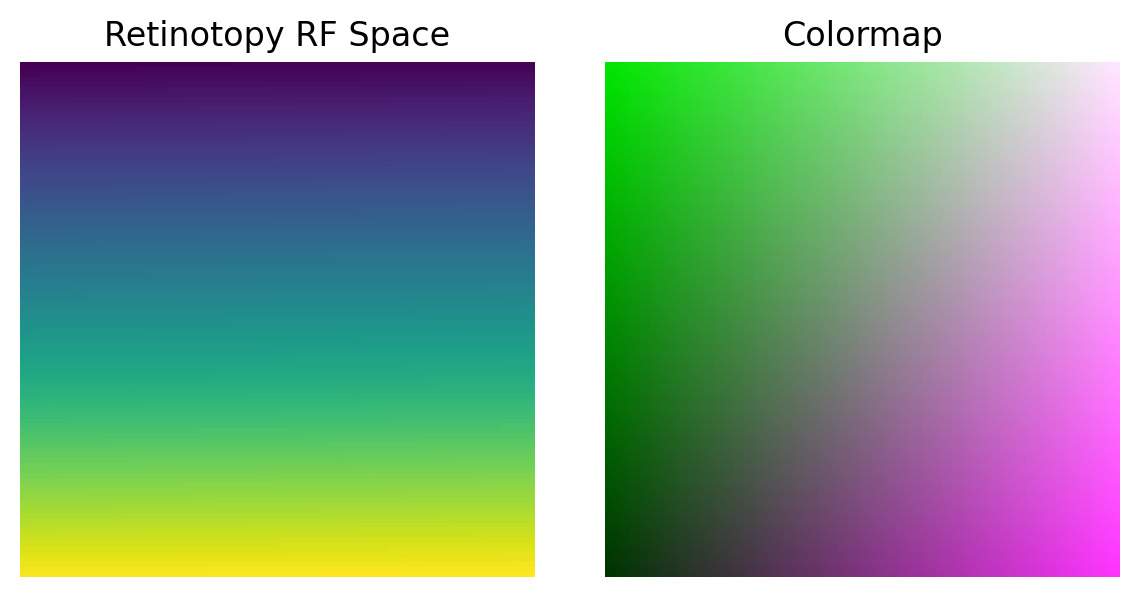

In [172]:
# make colormap for retinotopy
appdata.cmap, appdata.RetinotopyRFspace_plot = make_colormap(appdata.rf_space_x)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.imshow(appdata.RetinotopyRFspace_plot)
ax2.imshow(appdata.cmap)
ax1.set_title('Retinotopy RF Space')
ax2.set_title('Colormap')
ax1.axis('off')
ax2.axis('off')
plt.tight_layout()

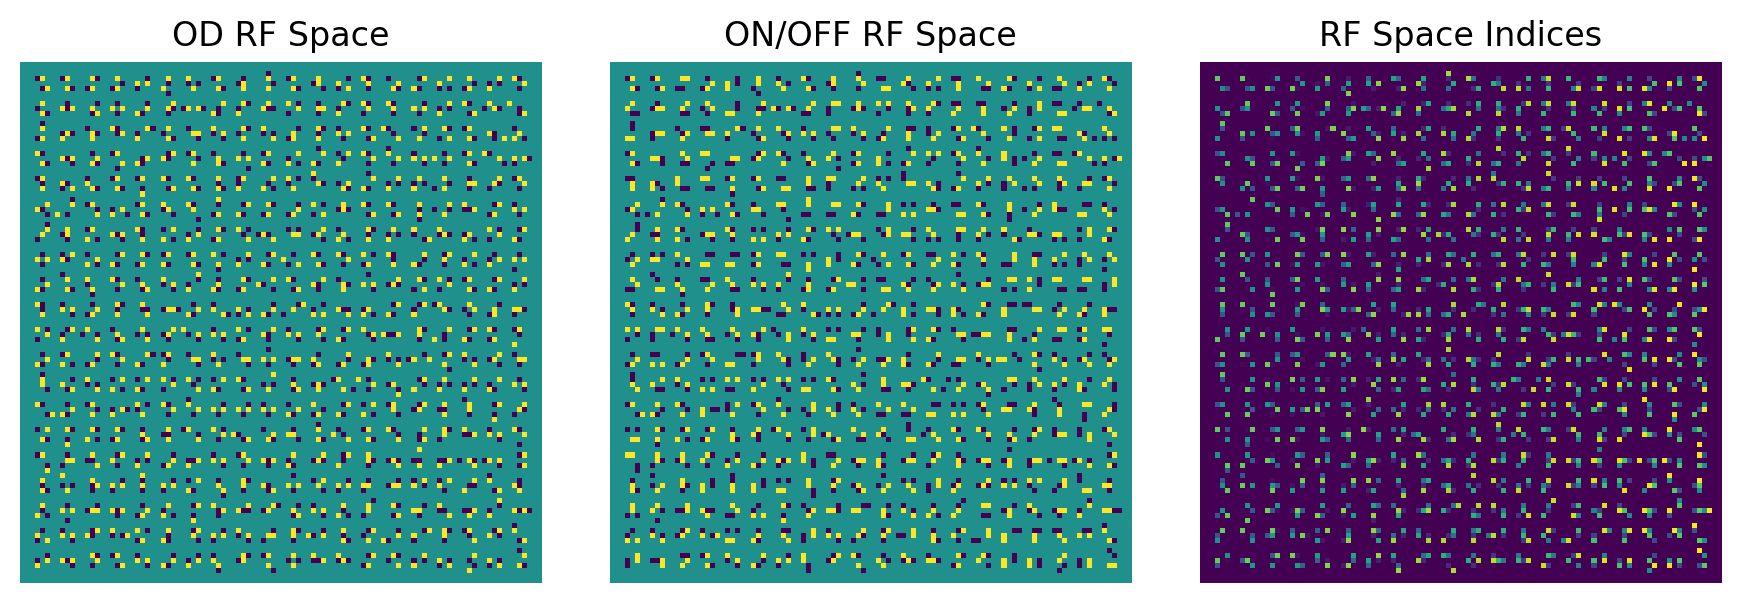

In [173]:
make_retina_grid_rf_space_app(appdata) # put RGCs into a matrix without changing the location (cortical plate)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
ax1.imshow(appdata.od_rf_space)
ax2.imshow(appdata.onoff_rf_space)
ax3.imshow(appdata.IndRetinaRfspace)
ax1.set_title('OD RF Space')
ax2.set_title('ON/OFF RF Space')
ax3.set_title('RF Space Indices')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.tight_layout()

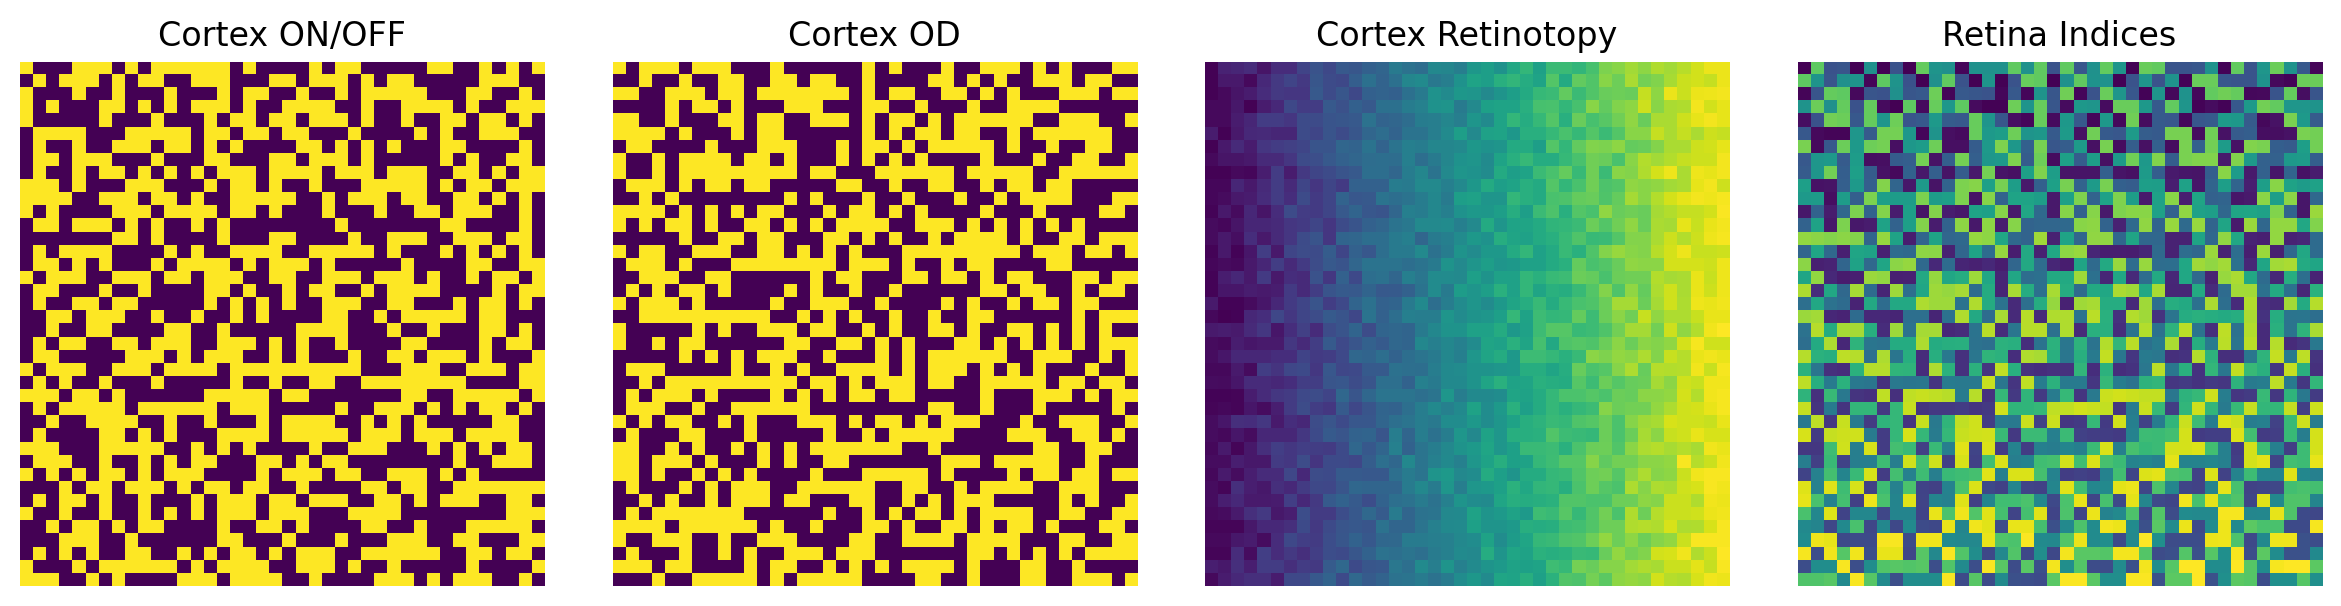

In [184]:
make_cortex_app(appdata) # builds cortex, sorted by retinotopy

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 3))
ax1.imshow(appdata.CrtxONOFF3m)
ax2.imshow(appdata.CrtxOD3m)
ax3.imshow(appdata.Retinotopy3mIndPlot)
ax4.imshow(appdata.Retinotopy3mIndex)
ax1.set_title('Cortex ON/OFF')
ax2.set_title('Cortex OD')
ax3.set_title('Cortex Retinotopy')
ax4.set_title('Retina Indices')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
plt.tight_layout()

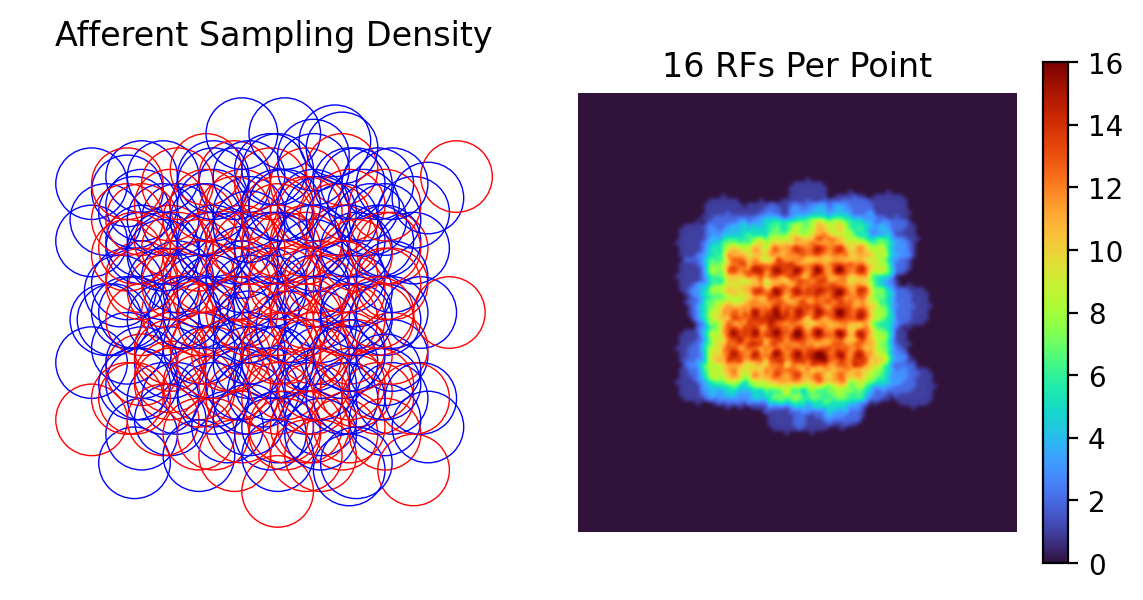

In [185]:
# plot thalamic afferents in visual space
update_thalamic_aff_UI(appdata)

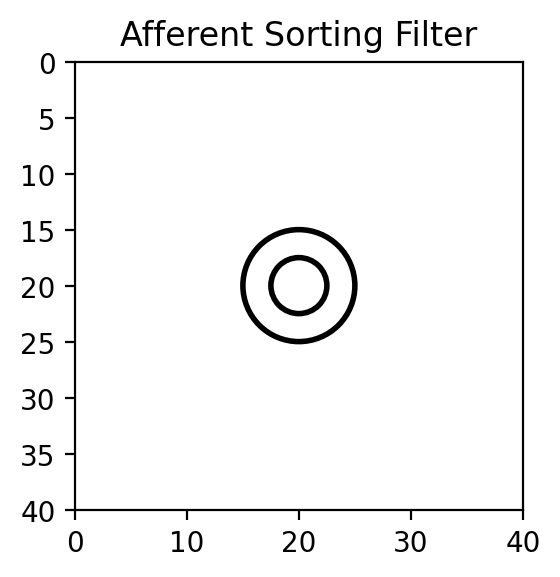

In [186]:
fig, ax = plt.subplots(figsize=(3, 3))
update_asf_figure(ax, appdata) # plot afferent sorting filter
plt.tight_layout()

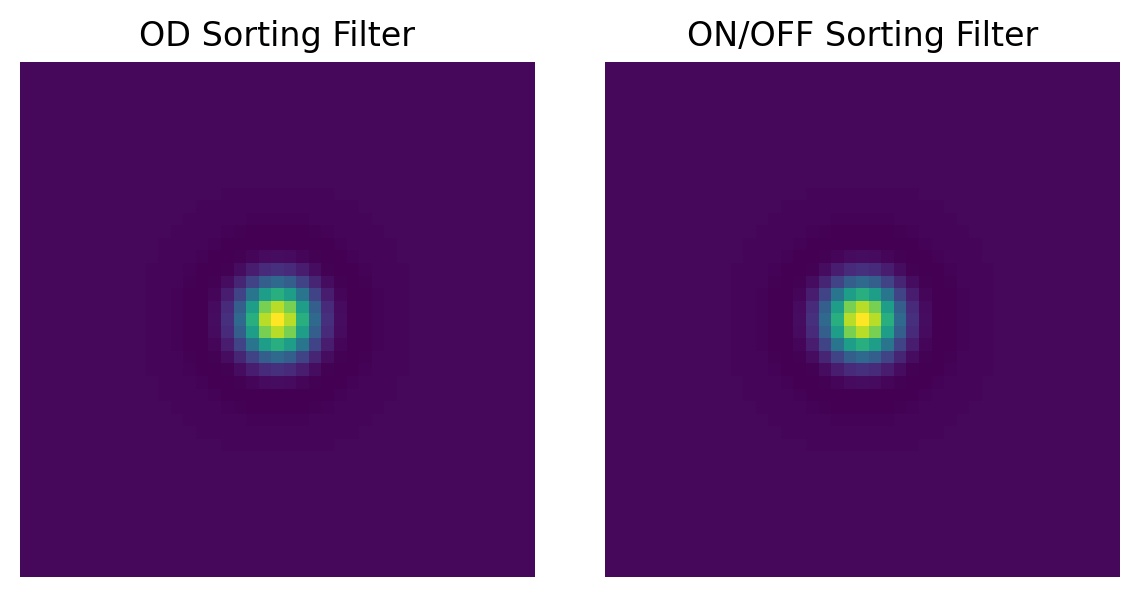

In [187]:
# the Y and X is reveresed for ONOFF filter comparing to OD filter
appdata.SortFiltOD = functionDoGfilter(
    appdata.CenterRadiusX, appdata.CenterRadiusY, appdata.SurroundRadiusX, appdata.SurroundRadiusY, appdata.CSRatio)
appdata.SortFiltONOFF = functionDoGfilter(
    appdata.CenterRadiusX, appdata.CenterRadiusY, appdata.SurroundRadiusY, appdata.SurroundRadiusX, appdata.CSRatio)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.imshow(appdata.SortFiltOD)
ax2.imshow(appdata.SortFiltONOFF)
ax1.set_title('OD Sorting Filter')
ax2.set_title('ON/OFF Sorting Filter')
ax1.axis('off')
ax2.axis('off')
plt.tight_layout()

  0%|          | 0/3 [00:00<?, ?it/s]

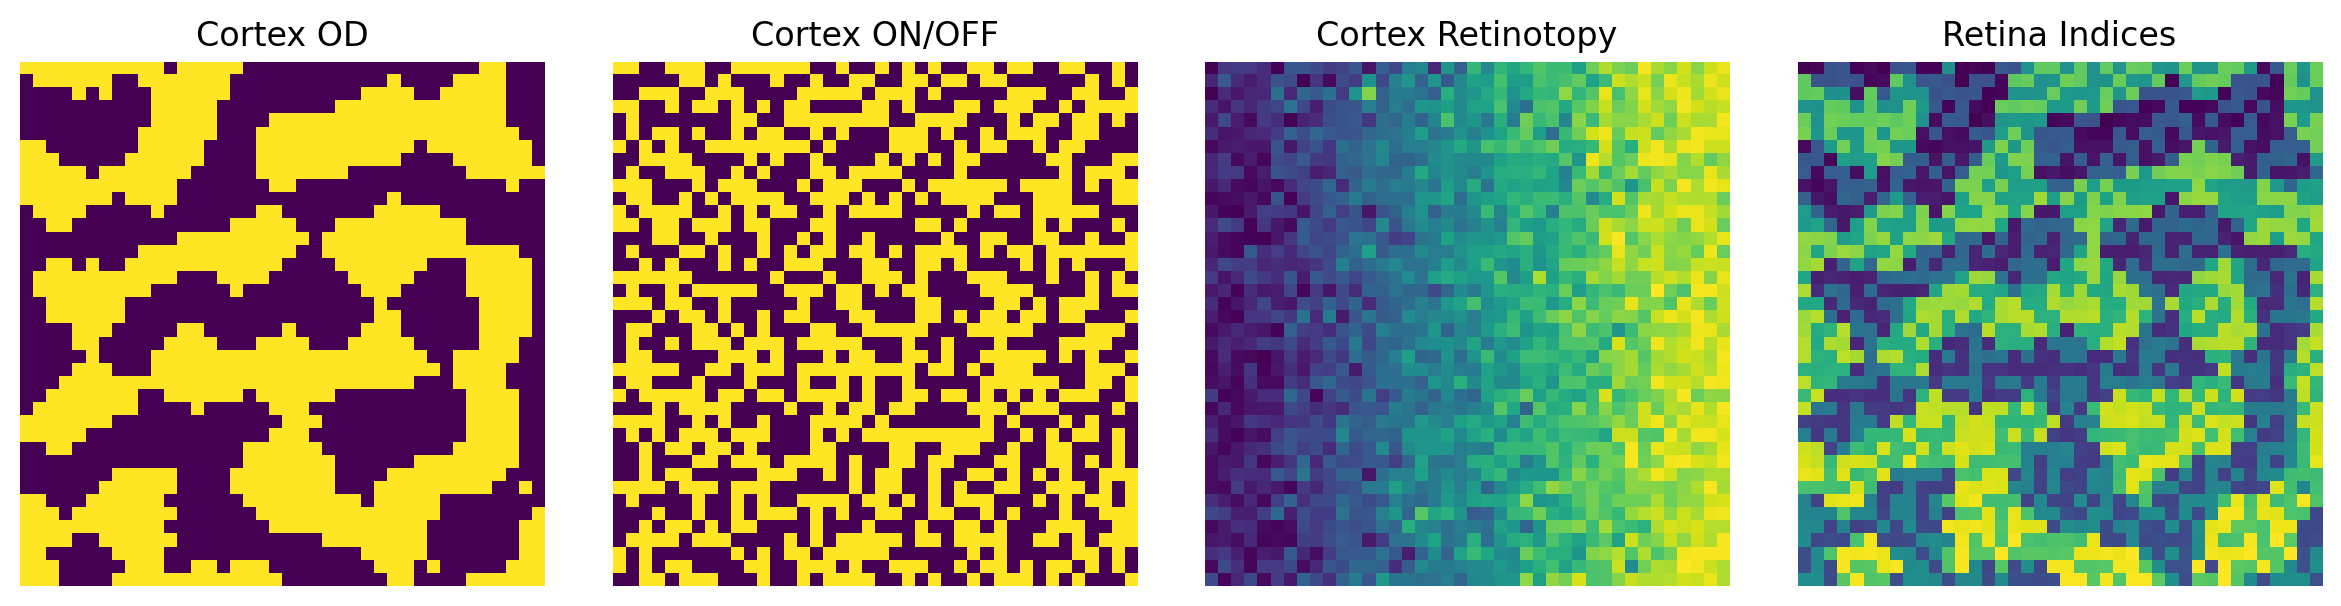

In [206]:
# sort afferents by OD
sort_afferent_od2_app(appdata)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 3))
ax1.imshow(appdata.OD_ODSort)
ax2.imshow(appdata.ONOFF_ODSort)
ax3.imshow(appdata.RetinotopyODSortedPlot)
ax4.imshow(appdata.RetODsorted)
ax1.set_title('Cortex OD')
ax2.set_title('Cortex ON/OFF')
ax3.set_title('Cortex Retinotopy')
ax4.set_title('Retina Indices')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
plt.tight_layout()

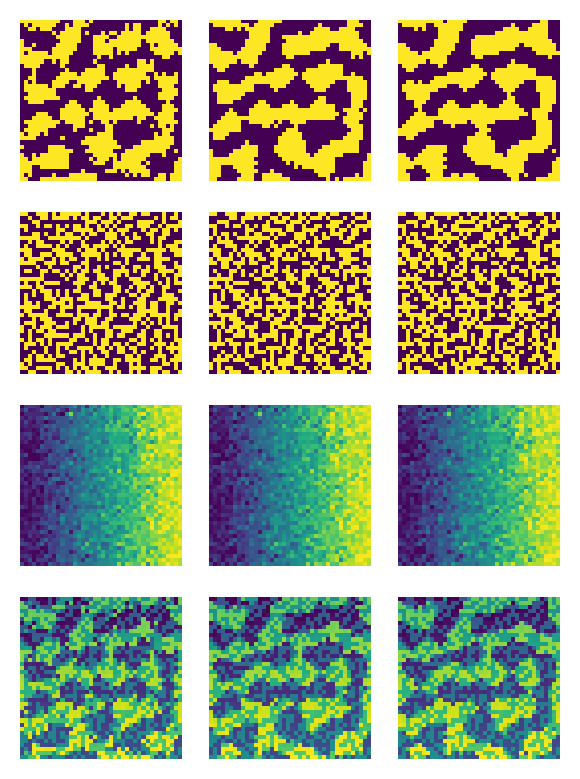

In [207]:
fig, axes = plt.subplots(4, appdata.NSortOD, figsize=(appdata.NSortOD, 4))
if len(axes.shape) == 1:
    axes = axes[:, None]
for i in range(appdata.NSortOD):
    odmap = appdata.map_step_holder.OD_holder[i]
    onoffmap = appdata.map_step_holder.ONOFF_holder[i]
    retmap = appdata.map_step_holder.retinotopy_holder[i]
    retpltmap = appdata.map_step_holder.retinotopy_plot_holder[i]
    axes[0, i].imshow(odmap)
    axes[0, i].axis('off')
    axes[1, i].imshow(onoffmap)
    axes[1, i].axis('off')
    axes[2, i].imshow(retpltmap)
    axes[2, i].axis('off')
    axes[3, i].imshow(retmap)
    axes[3, i].axis('off')
plt.tight_layout()

  0%|          | 0/3 [00:00<?, ?it/s]

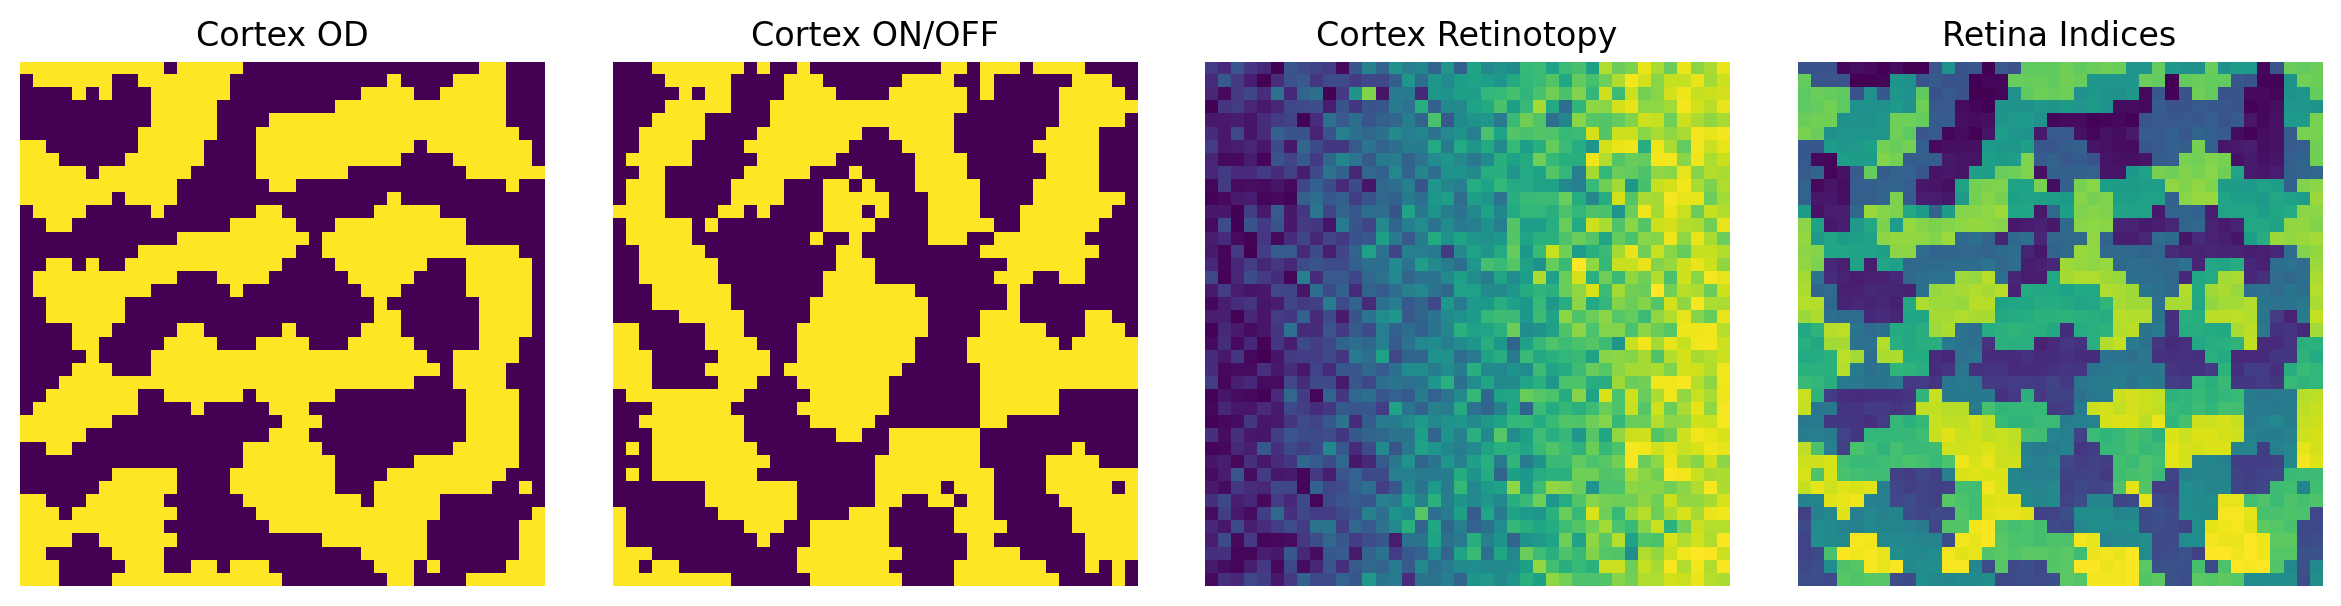

In [208]:
# sort afferents by ONOFF
sort_afferent_onoff2_app(appdata)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 3))
ax1.imshow(appdata.ODCrtxPlt)
ax2.imshow(appdata.ONOFFCrtxPlt)
ax3.imshow(appdata.RetinotopyONOFFSortedPlot)
ax4.imshow(appdata.RetONOFFsorted)
ax1.set_title('Cortex OD')
ax2.set_title('Cortex ON/OFF')
ax3.set_title('Cortex Retinotopy')
ax4.set_title('Retina Indices')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
plt.tight_layout()

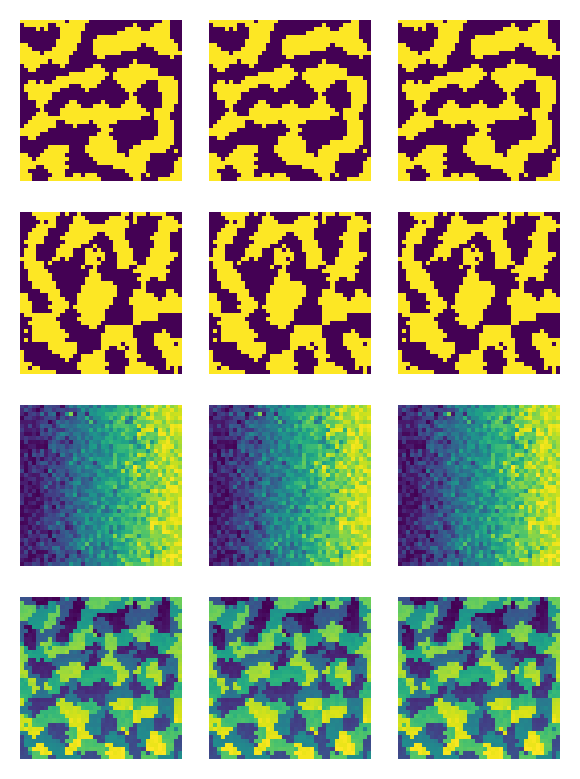

In [209]:
fig, axes = plt.subplots(4, appdata.NSortONOFF, figsize=(appdata.NSortONOFF, 4))
if len(axes.shape) == 1:
    axes = axes[:, None]
for i in range(appdata.NSortONOFF):
    odmap = appdata.ONOFFmap_step_holder.OD_holder[i]
    onoffmap = appdata.ONOFFmap_step_holder.ONOFF_holder[i]
    retmap = appdata.ONOFFmap_step_holder.retinotopy_holder[i]
    retpltmap = appdata.ONOFFmap_step_holder.retinotopy_plot_holder[i]
    axes[0, i].imshow(odmap)
    axes[1, i].imshow(onoffmap)
    axes[2, i].imshow(retpltmap)
    axes[3, i].imshow(retmap)
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    axes[2, i].axis('off')
    axes[3, i].axis('off')
plt.tight_layout()

In [210]:
smooth_map_app(appdata) # blur, normalize, then upsample the OD and ONOFF maps

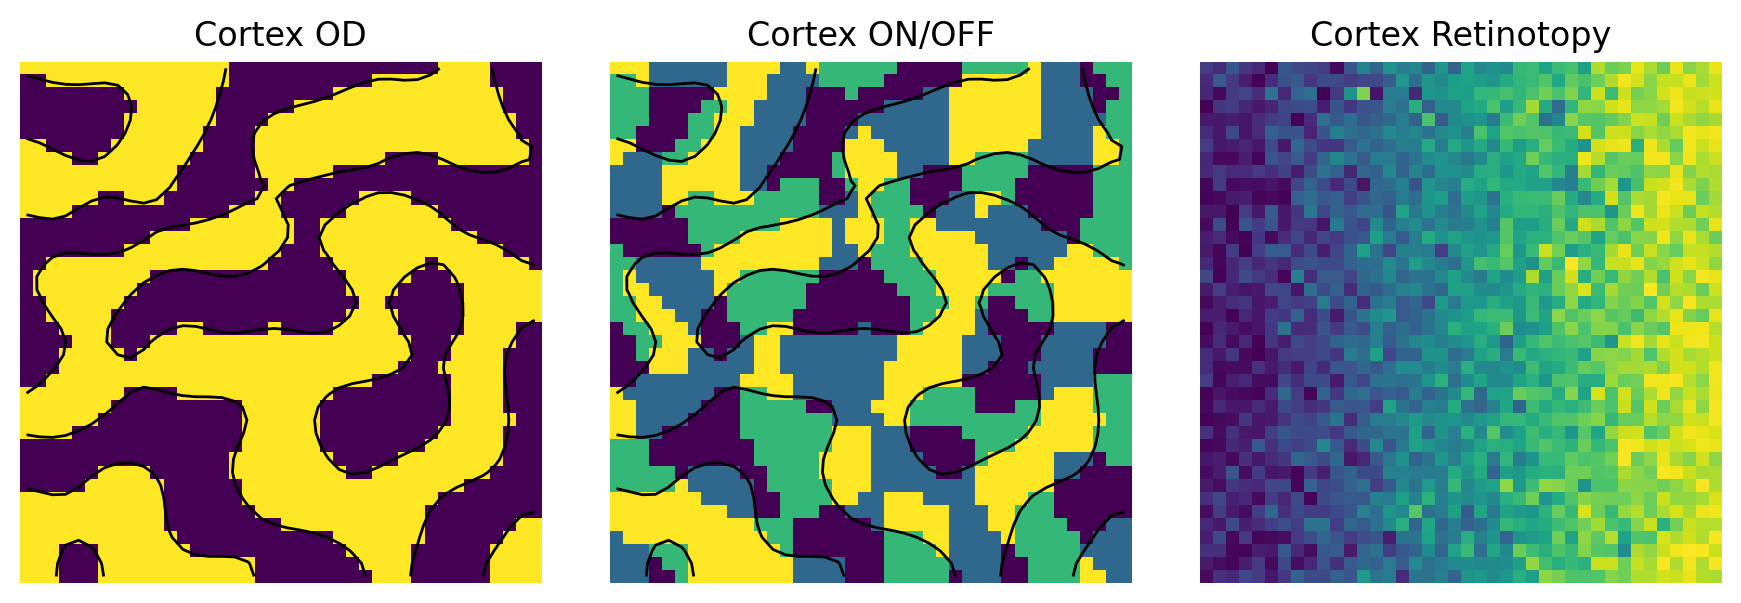

In [211]:
show_maps_segregation(appdata) # plot OD, ON and retinopy maps (using cmap)

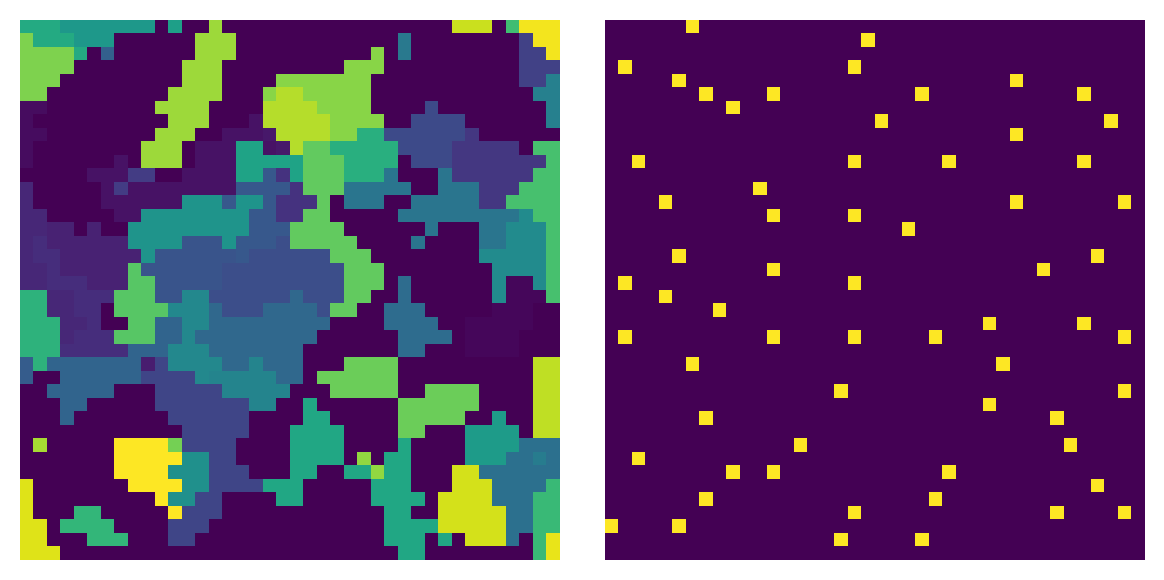

In [212]:
# labeling islands
appdata.ONOFFODLabelSorted, appdata.CenterPinwheelSorted, appdata.NumPinwheel, appdata.center_island_image = \
    label_ononff_od_island_gui(appdata)

# synaptic weight based on islands
appdata.weight_map_island = np.ones_like(appdata.ONOFFODLabelSorted)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.imshow(appdata.ONOFFODLabelSorted)
ax2.imshow(appdata.center_island_image)
ax1.axis('off')
ax2.axis('off')
plt.tight_layout()

In [213]:
# Making the receptive field in Retinal(Visual) Space with Gaussian functions
appdata.RetinaRF = make_rf_retina(appdata.TotalRetinaCells, appdata.RFONCenter, appdata.RFOFFCenter, appdata.IndRetinaRfspace, appdata.onoff_rf_space)

  0%|          | 0/1600 [00:00<?, ?it/s]

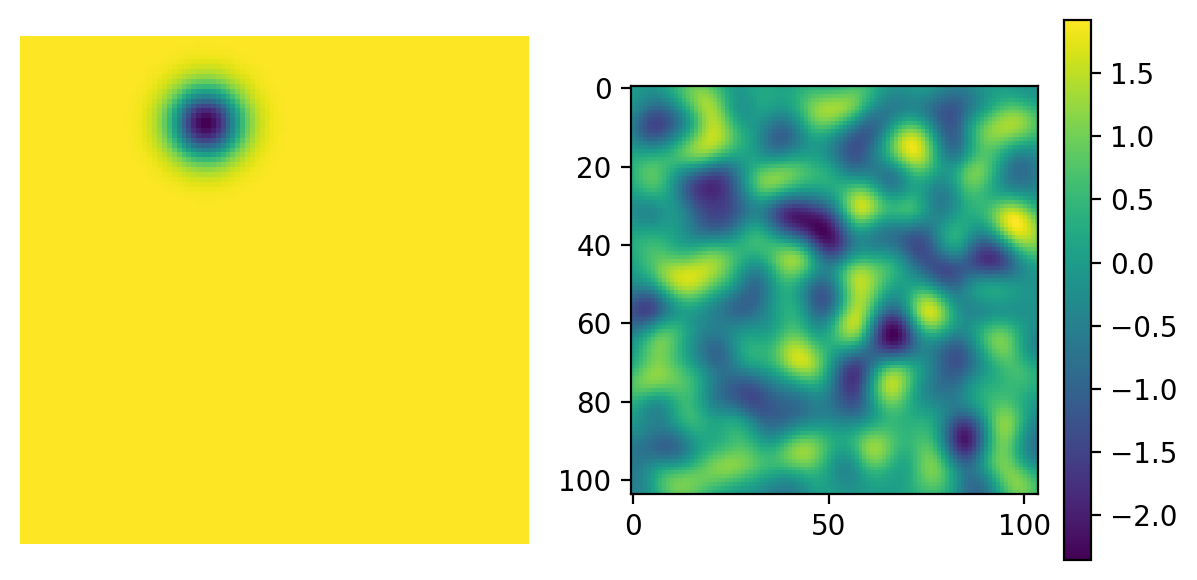

In [214]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.imshow(appdata.RetinaRF[np.random.randint(len(appdata.RetinaRF))])
cax = ax2.imshow(appdata.RetinaRF.sum(axis=0))
fig.colorbar(cax, ax=ax2)
ax1.axis('off')
plt.tight_layout()

In [215]:
# primordial measurements
generate_rf_cortex_primord_app_sn(appdata)
update_primord_orimap_UI(appdata)

TypeError: generate_rf_cortex_primordial_initial_gui() missing 2 required positional arguments: 'debug' and 'show_fig'